In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [2]:
pollution = pd.read_csv('registre-francais-des-emission-polluantes-emissions.csv', sep = ";")

In [3]:
pathologies = pd.read_csv('effectifs.csv', sep= ";")

C:\Users\Ramy Tlili\AppData\Local\Temp\ipykernel_14236\3995550939.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  pathologies = pd.read_csv('effectifs.csv', sep= ";")


Commençons par le traitement du premier dataset:

In [4]:
pollution.drop(columns=['Numéro Siret de l\'Etablissement', 'Libellé APE', 'Adresse', 'Code Postal', 'Commune', 'Coordonnées', 'Code INSEE'], inplace=True)


In [5]:
polluants = pollution['Polluant'].unique()


In [6]:

for polluant in polluants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    if not pollution_polluant['Unité'].mode().empty:
        top = pollution_polluant['Unité'].mode()[0]
        pollution.loc[pollution['Polluant'] == polluant, 'Unité'] = top



Certains polluants ne possèdent pas de mode, et dans notre cas, cela s'explique par une raison précise : toutes les valeurs de la colonne 'Unité' correspondant à ces polluants restants sont manquantes (NaN). Cependant, comme nous ne comparerons pas les différents polluants entre eux, mais uniquement les valeurs d'un même polluant, l'unité n'est pas déterminante. Nous avons d'ailleurs constaté que les valeurs semblent être du même ordre de grandeur. Par conséquent, nous allons remplir les valeurs manquantes avec 'kg/an'.

In [7]:
polluants_restants = pollution[pollution['Unité'].isna()]['Polluant'].unique()


In [8]:
Missing = [(pollution[pollution['Polluant'] == polluant]['Unité'].isna().sum(),
            pollution[pollution['Polluant'] == polluant].iloc[:, 0].count()) for polluant in polluants_restants]

print(Missing)


[(2554, 2554), (506, 506), (872, 872), (1287, 1287), (3425, 3425), (1367, 1367), (2198, 2198), (3281, 3281), (2025, 2025), (2214, 2214), (929, 929), (1439, 1439), (1732, 1732), (3997, 3997), (65, 65), (65, 65), (733, 733), (357, 357), (223, 223), (1797, 1797), (530, 530), (1748, 1748), (557, 557), (310, 310), (2501, 2501), (214, 214), (1191, 1191), (517, 517), (285, 285), (25, 25), (32, 32), (1128, 1128), (106, 106), (39, 39), (962, 962), (547, 547), (471, 471), (610, 610), (671, 671), (198, 198), (171, 171), (233, 233), (41, 41), (205, 205), (118, 118), (54, 54), (220, 220), (94, 94), (50, 50), (140, 140), (2, 2), (25, 25), (156, 156), (300, 300), (109, 109), (41, 41), (82, 82), (65, 65), (106, 106), (2, 2), (13, 13), (20, 20), (2, 2), (95, 95), (7, 7), (16, 16), (67, 67), (60, 60), (15, 15), (7, 7), (44, 44), (12, 12), (7, 7), (4, 4), (4, 4), (15, 15), (17, 17), (8, 8), (1, 1), (8, 8), (10, 10), (2, 2), (14, 14), (4, 4), (1, 1), (5, 5), (1, 1), (4, 4), (2, 2), (2, 2), (1, 1), (2, 2),

La ligne de code précédente renvoie des couples (nombre de valeurs manquantes dans la colonne 'Unité' pour un polluant donné, nombre total de lignes pour ce polluant). On observe que ces nombres sont égaux, ce qui confirme ce que nous venons d'expliquer.


In [9]:
for polluant in polluants_restants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    pollution.loc[pollution['Polluant'] == polluant, 'Unité'] = 'kg/an'

Maintenant on résoud le problème des données manquantes pour les départements et les régions. Ici on a pas de problème d'existence du mode.

In [10]:
departement_region = {
    'MORBIHAN': 'BRETAGNE',
    'NORD': 'HAUTS-DE-FRANCE',
    'RHONE': 'AUVERGNE-RHONE-ALPES',
    'SEINE-MARITIME': 'NORMANDIE',
    'BAS-RHIN': 'GRAND-EST',
    'LOIRET': 'CENTRE-VAL DE LOIRE',
    'FINISTERE': 'BRETAGNE',
    'ISERE': 'AUVERGNE-RHONE-ALPES',
    'BOUCHES-DU-RHONE': "PROVENCE-ALPES-COTE D'AZUR",
    'PYRENEES-ATLANTIQUES': 'NOUVELLE-AQUITAINE',
    'HAUTE-SAVOIE': 'AUVERGNE-RHONE-ALPES',
    'OISE': 'HAUTS-DE-FRANCE',
    'LANDES': 'NOUVELLE-AQUITAINE',
    'PAS-DE-CALAIS': 'HAUTS-DE-FRANCE',
    'MEURTHE-ET-MOSELLE': 'GRAND-EST',
    'MARNE': 'GRAND-EST',
    'JURA': 'BOURGOGNE-FRANCHE-COMTE',
    'HAUTES-PYRENEES': 'OCCITANIE',
    'ALLIER': 'AUVERGNE-RHONE-ALPES',
    'ALPES-DE-HAUTE-PROVENCE': "PROVENCE-ALPES-COTE D'AZUR",
    'HAUT-RHIN': 'GRAND-EST',
    'HAUTE-VIENNE': 'NOUVELLE-AQUITAINE',
    'GIRONDE': 'NOUVELLE-AQUITAINE',
    'EURE': 'NORMANDIE',
    'HERAULT': 'OCCITANIE',
    'INDRE-ET-LOIRE': 'CENTRE-VAL DE LOIRE',
    'REUNION': 'LA REUNION',
    'VIENNE': 'NOUVELLE-AQUITAINE',
    'HAUTS-DE-SEINE': 'ILE-DE-FRANCE',
    'VAR': "PROVENCE-ALPES-COTE D'AZUR",
    'DROME': 'AUVERGNE-RHONE-ALPES',
    'MOSELLE': 'GRAND-EST',
    'SAONE-ET-LOIRE': 'BOURGOGNE-FRANCHE-COMTE',
    'MAINE-ET-LOIRE': 'PAYS DE LA LOIRE',
    'CHER': 'CENTRE-VAL DE LOIRE',
    'EURE-ET-LOIR': 'CENTRE-VAL DE LOIRE',
    'LOIRE-ATLANTIQUE': 'PAYS DE LA LOIRE',
    'GARD': 'OCCITANIE',
    'AISNE': 'HAUTS-DE-FRANCE',
    'CALVADOS': 'NORMANDIE'
}

for polluant in polluants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    if not pollution_polluant['Departement'].mode().empty:
        top = pollution_polluant['Departement'].mode()[0]
        pollution.loc[(pollution['Polluant'] == polluant) & (pollution['Departement'].isna()), 'Departement'] = top
        pollution.loc[(pollution['Polluant'] == polluant ) & (pollution['Region'].isna()), 'Region'] = departement_region[top]



In [11]:
pathologies.drop(columns=['patho_niv2', 'patho_niv3'], inplace=True)


On constate qu'il y a une corrélation forte (elle vaut 1) au niveau des données manquantes entre NTop et prev, on ne peut pas calculer les valeurs manquantes de prev. On les enlève alors:

In [12]:
pathologies.dropna(subset=['prev'], inplace=True)

La région doit etre de type 'Object', on la transforme en 'str'

In [13]:
pathologies['region'] = pathologies['region'].astype(str)


__Création du Dataframe pour test et entrainement__

In [14]:
final_dataframe_list = []  

for annee_pathologie in range(2016, 2023):
    annee_pollution = annee_pathologie - 8
    polluants = pollution[pollution['Annee Emission'] == annee_pollution]['Polluant'].unique()
    cancer = pathologies[(pathologies['patho_niv1'] == 'Cancers') & (pathologies['annee'] == annee_pathologie)]
    prevalence_pr_departement = cancer.groupby('dept')['prev'].mean().reset_index()
    prevalence_pr_departement = prevalence_pr_departement[prevalence_pr_departement['dept'] != '999']
    
    departement_codes = {
        'AIN': '01', 'AISNE': '02', 'ALLIER': '03', 'ALPES-DE-HAUTE-PROVENCE': '04',
        'HAUTES-ALPES': '05', 'ALPES-MARITIMES': '06', 'ARDECHE': '07', 'ARDENNES': '08',
        'ARIEGE': '09', 'AUBE': '10', 'AUDE': '11', 'AVEYRON': '12', 'BOUCHES-DU-RHONE': '13',
        'CALVADOS': '14', 'CANTAL': '15', 'CHARENTE': '16', 'CHARENTE-MARITIME': '17',
        'CHER': '18', 'CORREZE': '19', "COTE-D'OR": '21', "COTES-D'ARMOR": '22',
        'CREUSE': '23', 'DORDOGNE': '24', 'DOUBS': '25', 'DROME': '26', 'EURE': '27',
        'EURE-ET-LOIR': '28', 'FINISTERE': '29', 'GARD': '30', 'HAUTE-GARONNE': '31',
        'GERS': '32', 'GIRONDE': '33', 'HERAULT': '34', 'ILLE-ET-VILAINE': '35',
        'INDRE': '36', 'INDRE-ET-LOIRE': '37', 'ISERE': '38', 'JURA': '39', 'LANDES': '40',
        'LOIR-ET-CHER': '41', 'LOIRE': '42', 'HAUTE-LOIRE': '43', 'LOIRE-ATLANTIQUE': '44',
        'LOIRET': '45', 'LOT': '46', 'LOT-ET-GARONNE': '47', 'LOZERE': '48',
        'MAINE-ET-LOIRE': '49', 'MANCHE': '50', 'MARNE': '51', 'HAUTE-MARNE': '52',
        'MAYENNE': '53', 'MEURTHE-ET-MOSELLE': '54', 'MEUSE': '55', 'MORBIHAN': '56',
        'MOSELLE': '57', 'NIEVRE': '58', 'NORD': '59', 'OISE': '60', 'ORNE': '61',
        'PAS-DE-CALAIS': '62', 'PUY-DE-DOME': '63', 'PYRENEES-ATLANTIQUES': '64',
        'HAUTES-PYRENEES': '65', 'PYRENEES-ORIENTALES': '66', 'BAS-RHIN': '67',
        'HAUT-RHIN': '68', 'RHONE': '69', 'HAUTE-SAONE': '70', 'SAONE-ET-LOIRE': '71',
        'SARTHE': '72', 'SAVOIE': '73', 'HAUTE-SAVOIE': '74', 'PARIS': '75',
        'SEINE-MARITIME': '76', 'SEINE-ET-MARNE': '77', 'YVELINES': '78', 'DEUX-SEVRES': '79',
        'SOMME': '80', 'TARN': '81', 'TARN-ET-GARONNE': '82', 'VAR': '83', 'VAUCLUSE': '84',
        'VENDEE': '85', 'VIENNE': '86', 'HAUTE-VIENNE': '87', 'VOSGES': '88', 'YONNE': '89',
        'TERRITOIRE-DE-BELFORT': '90', 'ESSONNE': '91', 'HAUTS-DE-SEINE': '92',
        'SEINE-SAINT-DENIS': '93', 'VAL-DE-MARNE': '94', "VAL-D'OISE": '95',
        'GUADELOUPE': '971', 'MARTINIQUE': '972', 'GUYANE': '973', 'LA REUNION': '974',
        'MAYOTTE': '976', 'CORSE-DU-SUD': '2A', 'HAUTE-CORSE': '2B'
    }
    
    prevalence_pr_departement['Departement'] = prevalence_pr_departement['dept'].map(
        {v: k for k, v in departement_codes.items()}
    )
    prevalence_pr_departement = prevalence_pr_departement.dropna(subset=['Departement']).drop(columns=['dept'])
    quantite_emise_final = prevalence_pr_departement.copy()
    
    for polluant in polluants:
        pol_ = pollution[(pollution['Annee Emission'] == annee_pollution) & (pollution['Polluant'] == polluant)]
        quantite_emise = pol_.groupby('Departement')['Quantité'].sum().reset_index()
        quantite_emise = quantite_emise.rename(columns={'Quantité': polluant})
        quantite_emise_final = quantite_emise_final.merge(
            quantite_emise, on='Departement', how='left'
        ).fillna({polluant: 0})
    
    quantite_emise_final['Annee Polluants'] = annee_pollution
    final_dataframe_list.append(quantite_emise_final)

final_dataframe = pd.concat(final_dataframe_list, ignore_index=True)
final_dataframe.fillna(0, inplace=True)

print(final_dataframe.head())


       prev              Departement  Ammoniac (NH3)  \
0  2.790305                      AIN       1354900.0   
1  2.626217                    AISNE         75700.0   
2  3.167435                   ALLIER        127500.0   
3  3.295936  ALPES-DE-HAUTE-PROVENCE             0.0   
4  3.526160             HAUTES-ALPES             0.0   

   Demande chimique en oxygène (DCO)  Demande biologique en oxygène (DBO5)  \
0                          1111000.0                              470800.0   
1                          3357000.0                              600300.0   
2                          1215000.0                              319400.0   
3                                0.0                               62600.0   
4                                0.0                                   0.0   

   Azote total (N)  Benzo[a]pyrène (benzo[d - e - f]chrysène)  \
0          61400.0                                   0.000000   
1         220400.0                                   0.110046   

In [15]:
final_dataframe.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 133 columns):
 #    Column                                                                                      Dtype  
---   ------                                                                                      -----  
 0    prev                                                                                        float64
 1    Departement                                                                                 object 
 2    Ammoniac (NH3)                                                                              float64
 3    Demande chimique en oxygène (DCO)                                                           float64
 4    Demande biologique en oxygène (DBO5)                                                        float64
 5    Azote total (N)                                                                             float64
 6    Benzo[a]pyrène (benzo[d - e - f]chrysène

In [16]:
pollutant_corr_matrix = final_dataframe.iloc[:, 2:].corr()
threshold = 0.8
high_corr_pairs = [
    (col1, col2) 
    for col1 in pollutant_corr_matrix.columns 
    for col2 in pollutant_corr_matrix.columns 
    if col1 != col2 and abs(pollutant_corr_matrix.loc[col1, col2]) > threshold
]
print(high_corr_pairs)


[('Demande chimique en oxygène (DCO)', 'Demande biologique en oxygène (DBO5)'), ('Demande chimique en oxygène (DCO)', 'Phosphore total (P)'), ('Demande biologique en oxygène (DBO5)', 'Demande chimique en oxygène (DCO)'), ('Demande biologique en oxygène (DBO5)', 'Phosphore total (P)'), ('Benzo[a]pyrène (benzo[d - e - f]chrysène)', 'Benzo(b)fluoranthène'), ('Benzo[a]pyrène (benzo[d - e - f]chrysène)', 'Benzo(k)fluoranthène'), ('Benzo[a]pyrène (benzo[d - e - f]chrysène)', 'Indeno(1 - 2 - 3-cd)pyrène'), ('Nickel et ses composés (Ni)', 'Vanadium et ses composés'), ('Phosphore total (P)', 'Demande chimique en oxygène (DCO)'), ('Phosphore total (P)', 'Demande biologique en oxygène (DBO5)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Composés organiques volatils non méthaniques (COVNM)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', "Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)"), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Benzène'), ('Oxydes de soufre (SOx - SO2 + S

In [17]:
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    features_to_remove.add(col2)

final_dataframe_reduced = final_dataframe.drop(columns=features_to_remove)
print(final_dataframe_reduced.info(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 97 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   prev                                                                                        707 non-null    float64
 1   Departement                                                                                 707 non-null    object 
 2   Ammoniac (NH3)                                                                              707 non-null    float64
 3   Azote total (N)                                                                             707 non-null    float64
 4   Zinc et ses composés (Zn)                                                                   707 non-null    float64
 5   Di(2-éthylhexyle)phtalate (DEHP)           

In [18]:
print(final_dataframe_reduced)

         prev              Departement  Ammoniac (NH3)  Azote total (N)  \
0    2.790305                      AIN       1354900.0          61400.0   
1    2.626217                    AISNE         75700.0         220400.0   
2    3.167435                   ALLIER        127500.0          52200.0   
3    3.295936  ALPES-DE-HAUTE-PROVENCE             0.0              0.0   
4    3.526160             HAUTES-ALPES             0.0              0.0   
..        ...                      ...             ...              ...   
702  2.550094               GUADELOUPE             0.0              0.0   
703  2.370565               MARTINIQUE         49000.0              0.0   
704  2.093977                   GUYANE             0.0              0.0   
705  1.758066               LA REUNION             0.0              0.0   
706  1.088890                  MAYOTTE             0.0              0.0   

     Zinc et ses composés (Zn)  Di(2-éthylhexyle)phtalate (DEHP)  \
0                       1825.0 

In [19]:
X = final_dataframe_reduced.drop(columns=['prev', 'Departement'])
y = final_dataframe_reduced['prev']
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

features_to_remove = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=features_to_remove)



                                              Feature        VIF
70                Chlorométhane (chlorure de méthyle)  11.556622
89                                    Chlorfenvinphos  10.212669
43                                    1 - 3-butadiène   9.817138
32  Chlorure de vinyle (chloroéthylène - monochlor...   8.617553
52                                          Hydrazine   7.936666
..                                                ...        ...
62                            Hydrocarbures (C total)   1.113251
48                       Méthanol (alcool méthylique)   1.100331
81                          Tributylétain et composés   1.052289
26                                       Nonylphénols   1.032260
92                                            Amiante   1.031776

[95 rows x 2 columns]


In [20]:
print(final_dataframe)

         prev              Departement  Ammoniac (NH3)  \
0    2.790305                      AIN       1354900.0   
1    2.626217                    AISNE         75700.0   
2    3.167435                   ALLIER        127500.0   
3    3.295936  ALPES-DE-HAUTE-PROVENCE             0.0   
4    3.526160             HAUTES-ALPES             0.0   
..        ...                      ...             ...   
702  2.550094               GUADELOUPE             0.0   
703  2.370565               MARTINIQUE         49000.0   
704  2.093977                   GUYANE             0.0   
705  1.758066               LA REUNION             0.0   
706  1.088890                  MAYOTTE             0.0   

     Demande chimique en oxygène (DCO)  Demande biologique en oxygène (DBO5)  \
0                            1111000.0                              470800.0   
1                            3357000.0                              600300.0   
2                            1215000.0                         

In [21]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 93 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Ammoniac (NH3)                                                                              707 non-null    float64
 1   Azote total (N)                                                                             707 non-null    float64
 2   Zinc et ses composés (Zn)                                                                   707 non-null    float64
 3   Di(2-éthylhexyle)phtalate (DEHP)                                                            707 non-null    float64
 4   Carbone organique total (COT)                                                               707 non-null    float64
 5   Diuron                                     

Pour chaque maladie, on choisira le nombre

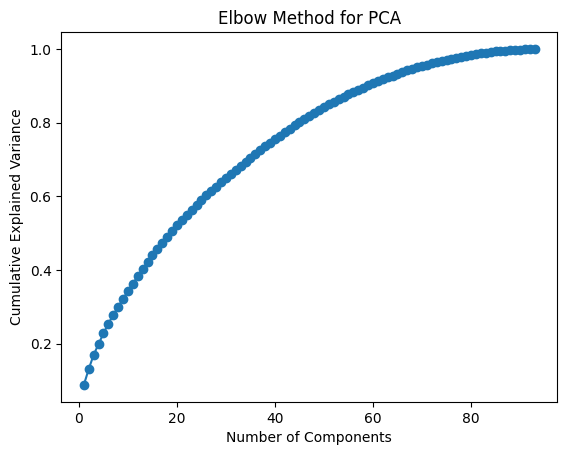


Explained Variance Percentage for Each Component:
Principal Component 1: 8.79%
Principal Component 2: 4.29%
Principal Component 3: 3.86%
Principal Component 4: 2.94%
Principal Component 5: 2.88%
Principal Component 6: 2.66%
Principal Component 7: 2.37%
Principal Component 8: 2.22%
Principal Component 9: 2.18%
Principal Component 10: 2.08%
Principal Component 11: 2.05%
Principal Component 12: 1.96%
Principal Component 13: 1.93%
Principal Component 14: 1.92%
Principal Component 15: 1.82%
Principal Component 16: 1.80%
Principal Component 17: 1.68%
Principal Component 18: 1.60%
Principal Component 19: 1.55%
Principal Component 20: 1.53%
Principal Component 21: 1.46%
Principal Component 22: 1.39%
Principal Component 23: 1.37%
Principal Component 24: 1.34%
Principal Component 25: 1.29%
Principal Component 26: 1.27%
Principal Component 27: 1.23%
Principal Component 28: 1.20%
Principal Component 29: 1.17%
Principal Component 30: 1.15%
Principal Component 31: 1.14%
Principal Component 32: 1.11

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_PCA = pca.fit_transform(X_scaled)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.show()


explained_variance_percentage = pca.explained_variance_ratio_ * 100
print("\nExplained Variance Percentage for Each Component:")
for i, variance in enumerate(explained_variance_percentage):
    print(f"Principal Component {i + 1}: {variance:.2f}%")



In [23]:
X_PCA_45 = X_PCA[:, :45]

X_PCA_45_df = pd.DataFrame(X_PCA_45, columns=[f"PC{i+1}" for i in range(45)])

X_PCA_45_df.info()

print(X_PCA_45_df.head())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     707 non-null    float64
 1   PC2     707 non-null    float64
 2   PC3     707 non-null    float64
 3   PC4     707 non-null    float64
 4   PC5     707 non-null    float64
 5   PC6     707 non-null    float64
 6   PC7     707 non-null    float64
 7   PC8     707 non-null    float64
 8   PC9     707 non-null    float64
 9   PC10    707 non-null    float64
 10  PC11    707 non-null    float64
 11  PC12    707 non-null    float64
 12  PC13    707 non-null    float64
 13  PC14    707 non-null    float64
 14  PC15    707 non-null    float64
 15  PC16    707 non-null    float64
 16  PC17    707 non-null    float64
 17  PC18    707 non-null    float64
 18  PC19    707 non-null    float64
 19  PC20    707 non-null    float64
 20  PC21    707 non-null    float64
 21  PC22    707 non-null    float64
 22  PC

Data pour la prédiction de l'an 2022 

In [ ]:
x_test=X_PCA_45_df[606:707]
x_train=X_PCA_45_df[0:606]

y_train=y[0:606]
y_test=y[606:707]



## Comparaison des modèles ##

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
import numpy as np

# Define parameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None,5,8,10,12],
        "min_samples_split": [2, 5]
    },
    "Decision Tree": {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.3]
    },
    "AdaBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.1, 0.5, 1.0]
    },
    "SVR": {
        "C": [0.1, 1, 10],
        "epsilon": [0.01, 0.1, 0.2]
    },
    "MLP Regressor": {
        "hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "max_iter": [200, 500]
    },
    "KNeighbors Regressor": {
        "n_neighbors": [3, 5, 10],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski", "euclidean"]
    },
    "Gaussian Process Regressor": {
        # Limited options since Gaussian Process is computationally intensive
        # Consider using a custom kernel or limiting the dataset size
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}

# Initialize results dictionary
best_params = {}
best_scores = {}

# Perform grid search for each model
for model_name, model in models.items():
    if model_name in param_grids and param_grids[model_name]:  # Ensure the model has a parameter grid
        print(f"Running GridSearchCV for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
            cv=5,
            n_jobs=-1
        )
        grid_search.fit(x_train, y_train)
        
        # Store best parameters and score
        best_params[model_name] = grid_search.best_params_
        best_scores[model_name] = -grid_search.best_score_  # Negate since scoring is negative MSE

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best MSE for {model_name}: {best_scores[model_name]:.4f}")
        print()

# Display final results
print("Summary of Best Parameters and Scores:")
for model_name in best_params.keys():
    print(f"{model_name}:")
    print(f"  Best Parameters: {best_params[model_name]}")
    print(f"  Best MSE: {best_scores[model_name]:.4f}")
    print()


Running GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Best MSE for Random Forest: 0.1206

Running GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Best MSE for Decision Tree: 0.1684

Running GridSearchCV for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best MSE for XGBoost: 0.1156

Running GridSearchCV for AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 0.5, 'n_estimators': 50}
Best MSE for AdaBoost: 0.1305

Running GridSearchCV for SVR...
Best parameters for SVR: {'C': 1, 'epsilon': 0.01}
Best MSE for SVR: 0.0997

Running GridSearchCV for MLP Regressor...


C:\Users\Ramy Tlili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP Regressor: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'max_iter': 200, 'solver': 'sgd'}
Best MSE for MLP Regressor: 0.1674

Running GridSearchCV for KNeighbors Regressor...
Best parameters for KNeighbors Regressor: {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}
Best MSE for KNeighbors Regressor: 0.1311

Running GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
Best MSE for Gradient Boosting: 0.1202

Summary of Best Parameters and Scores:
Random Forest:
  Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
  Best MSE: 0.1206

Decision Tree:
  Best Parameters: {'max_depth': 10, 'min_samples_split': 5}
  Best MSE: 0.1684

XGBoost:
  Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  Best MSE: 0.1156

AdaBoost:
  Best Parameters: {'learning_rate': 0.5, 'n_estimators': 50}
  Best MSE: 0.1305

SVR:

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import numpy as np

# Define models with optimized parameters
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=50, max_depth=5, min_samples_split=5, random_state=42
    ),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=10, min_samples_split=5, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.01, random_state=42
    ),
    "AdaBoost": AdaBoostRegressor(
        n_estimators=50, learning_rate=0.5, random_state=42
    ),
    "SVR": SVR(kernel='rbf', C=1, epsilon=0.01),
    "MLP Regressor": MLPRegressor(
        hidden_layer_sizes=(100, 50), activation='tanh', solver='sgd', max_iter=200, random_state=42
    ),
    "KNeighbors Regressor": KNeighborsRegressor(
        n_neighbors=10, weights='uniform', metric='minkowski'
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42
    )
}

# Number of splits for K-Fold
k_folds = 15
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare results dictionary
results = {model_name: {"MSE": [], "MAE": [], "R2": [], "RMSE": []} for model_name in models.keys()}

# Perform K-Fold cross-validation
for train_idx, val_idx in kf.split(x_train):
    x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    for model_name, model in models.items():
        # Train the model
        model.fit(x_train_fold, y_train_fold)

        # Predict on validation set
        y_pred = model.predict(x_val_fold)

        # Compute metrics
        mse = mean_squared_error(y_val_fold, y_pred)
        mae = mean_absolute_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        rmse = np.sqrt(mse)

        # Save metrics
        results[model_name]["MSE"].append(mse)
        results[model_name]["MAE"].append(mae)
        results[model_name]["R2"].append(r2)
        results[model_name]["RMSE"].append(rmse)

# Calculate mean MSE for each model
mean_mse = {model_name: np.mean(metrics['MSE']) for model_name, metrics in results.items()}

# Sort models by mean MSE from least to highest
sorted_models = sorted(mean_mse.items(), key=lambda x: x[1])

# Print results for models sorted by MSE
for model_name, _ in sorted_models:
    metrics = results[model_name]
    print(f"{model_name}:")
    print(f"  Mean MSE: {np.mean(metrics['MSE']):.4f} ± {np.std(metrics['MSE']):.4f}")
    print(f"  Mean MAE: {np.mean(metrics['MAE']):.4f} ± {np.std(metrics['MAE']):.4f}")
    print(f"  Mean R2: {np.mean(metrics['R2']):.4f} ± {np.std(metrics['R2']):.4f}")
    print(f"  Mean RMSE: {np.mean(metrics['RMSE']):.4f} ± {np.std(metrics['RMSE']):.4f}")
    print()


SVR:
  Mean MSE: 0.1000 ± 0.0460
  Mean MAE: 0.1931 ± 0.0369
  Mean R2: 0.1829 ± 0.0987
  Mean RMSE: 0.3067 ± 0.0772

XGBoost:
  Mean MSE: 0.1131 ± 0.0497
  Mean MAE: 0.2198 ± 0.0383
  Mean R2: 0.0639 ± 0.1139
  Mean RMSE: 0.3271 ± 0.0780

Random Forest:
  Mean MSE: 0.1163 ± 0.0549
  Mean MAE: 0.2137 ± 0.0331
  Mean R2: 0.0051 ± 0.3224
  Mean RMSE: 0.3312 ± 0.0812

Gradient Boosting:
  Mean MSE: 0.1186 ± 0.0606
  Mean MAE: 0.2145 ± 0.0362
  Mean R2: 0.0069 ± 0.3260
  Mean RMSE: 0.3328 ± 0.0885

KNeighbors Regressor:
  Mean MSE: 0.1207 ± 0.0592
  Mean MAE: 0.2267 ± 0.0357
  Mean R2: 0.0054 ± 0.1657
  Mean RMSE: 0.3367 ± 0.0859

AdaBoost:
  Mean MSE: 0.1255 ± 0.0682
  Mean MAE: 0.2266 ± 0.0411
  Mean R2: -0.0558 ± 0.4390
  Mean RMSE: 0.3412 ± 0.0952

MLP Regressor:
  Mean MSE: 0.1730 ± 0.0613
  Mean MAE: 0.2867 ± 0.0454
  Mean R2: -0.5783 ± 0.5923
  Mean RMSE: 0.4087 ± 0.0774

Decision Tree:
  Mean MSE: 0.1795 ± 0.0767
  Mean MAE: 0.2446 ± 0.0332
  Mean R2: -0.6945 ± 0.7366
  Mean RMSE: 

In [ ]:
import pandas as pd
import numpy as np

# Define models
models = {
    "SVR": SVR(kernel='rbf', C=1, epsilon=0.01),
    "KNeighbors Regressor": KNeighborsRegressor(
        n_neighbors=10, weights='uniform', metric='minkowski'
    )
}

# Create a dataframe to store results
results_df = pd.DataFrame()

# Iterate through the models and make predictions
for model_name, model in models.items():
    # Fit the model
    model.fit(x_train, y_train)  # Assuming x_train and y_train are available
    # Make predictions on the test data
    y_pred = model.predict(x_test)
    
    temp_df = pd.DataFrame({
        "True Value": y_test,
        f"Predicted Value ({model_name})": y_pred,
        f"Difference ({model_name})": abs(y_test - y_pred)
    })
    results_df = pd.concat([results_df, temp_df], axis=1)

# Remove duplicate columns
results_df = results_df.loc[:,~results_df.columns.duplicated()]

# Display the results
print(results_df)


     True Value  Predicted Value (SVR)  Difference (SVR)  \
606    2.718709               2.810417          0.091707   
607    2.707403               2.781569          0.074166   
608    3.272814               2.711176          0.561638   
609    3.393718               3.427060          0.033342   
610    3.573994               2.812394          0.761599   
..          ...                    ...               ...   
702    2.550094               2.779636          0.229542   
703    2.370565               2.799857          0.429291   
704    2.093977               2.789322          0.695344   
705    1.758066               2.818098          1.060032   
706    1.088890               2.816012          1.727122   

     Predicted Value (KNeighbors Regressor)  Difference (KNeighbors Regressor)  
606                                2.792171                           0.073461  
607                                2.738105                           0.030702  
608                                2